In [ ]:
# We import what is necessary to make the sprint project

from nba_api.stats.endpoints import commonallplayers # Point 1.1
from nba_api.stats.endpoints import commonplayerinfo # Point 1.2
from nba_api.stats.endpoints import playercareerstats # Point 1.3
from nba_api.stats.endpoints import PlayerProfileV2 # Point 1.4

from time import sleep
import pandas as pd
import numpy as np
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from dateutil import relativedelta
import geopandas



COLLECTING INFORMATION FOR BUILDING OUR DATASET 

-------------------- POINT 1.1 --------------------

In [ ]:
# Define the fuction 
def get_and_save_players_list():

    # we bring the players active
    players = commonallplayers.CommonAllPlayers(season = "2021-22")
    players_df = players.get_data_frames()[0]

    # Generate the mask
    mask = (players_df[(players_df.TEAM_ID == 0) | (players_df.GAMES_PLAYED_FLAG == "N") | (players_df.PERSON_ID == 1630597) ].index) 

    # Add the mask to Data Frame
    players_df = players_df.drop(mask)

    # Select the columns needed
    players_df = (players_df[["PERSON_ID","DISPLAY_FIRST_LAST","TEAM_NAME"]])

    # Rename the columns
    players_df.columns=["PERSON_ID","PLAYER_NAME", "TEAM_NAME"]

    return players_df
    



In [ ]:
current_players_list = get_and_save_players_list()
current_players_list.to_csv("nba_current_players_list.csv")

-------------------- POINT 1.2 --------------------

In [ ]:
# Define the fuction
def get_players_personal_information(current_players_list):

    # Inicialize Data Frame 
    players_info_point2 = pd.DataFrame()
    
    # We go through the data frame with active players
    for player in current_players_list["PERSON_ID"]:
        
        try:
            # We extract the necessary information
            personal_info = commonplayerinfo.CommonPlayerInfo(player_id=player).get_data_frames()[0]
            personal_info = personal_info[["PERSON_ID","BIRTHDATE","POSITION","COUNTRY","HEIGHT","WEIGHT","SCHOOL","SEASON_EXP","DRAFT_NUMBER"]]
        
        # In the case of error
        except Exception as err:
            print(f"ID ERROR : {player}, ERROR : {err}")
            # In the case of find error, continue...
            continue
        
        # Concat the info
        players_info_point2 = pd.concat([players_info_point2,personal_info])
        
        sleep(0.4)
    
    return players_info_point2

In [ ]:
players_personal_info = get_players_personal_information(current_players_list)
players_personal_info.to_csv("nba_players_personal_info.csv")

-------------------- POINT 1.3 --------------------

In [ ]:
# Define the fuction
def get_players_career_stats(current_players_list):

    # Inicialize Data Frame 
    players_stats_point3 = pd.DataFrame()
    
    # We go through the data frame with active players
    for player in current_players_list["PERSON_ID"]: 

        try:
            # We extract the necessary information
            personal_info_stats = playercareerstats.PlayerCareerStats(player_id=player).season_totals_regular_season.get_dict()
            personal_info_stats = pd.DataFrame(data=personal_info_stats["data"],columns=personal_info_stats["headers"])
            personal_info_stats = personal_info_stats[["PLAYER_ID","GP","MIN","PTS","REB","AST","STL","BLK"]]
        
        # In the case of error
        except Exception as err:         
            print(f"ID ERROR : {player} , ERROR: {err}")
             # In the case of find error, continue...
            continue 

        # Concat the info
        players_stats_point3 = pd.concat([players_stats_point3,personal_info_stats])

        sleep(0.4)
    
    # Delete ID duplicates 
    players_stats_point3 = players_stats_point3.drop_duplicates(subset=["PLAYER_ID"])

    # Rename column
    players_stats_point3.rename(columns={"PLAYER_ID":"PERSON_ID"},inplace=True)

    return players_stats_point3




In [ ]:
players_career_stats = get_players_career_stats(current_players_list)
players_career_stats.to_csv("nba_players_career_stats.csv")

-------------------- POINT 1.4 --------------------

In [ ]:
# Define the fuction
def get_players_next_game(current_players_list):

    # Inicialize the Data Frame
    players_next_game_point4 = pd.DataFrame()
    
    # We go through the data frame with active players
    for player in current_players_list["PERSON_ID"]: 
        
        try:
            # We extract the necessary information
            player_game = PlayerProfileV2(player_id=player).get_data_frames()[12] 
            players_next_game_point4 = pd.concat([players_next_game_point4,player_game])
            players_next_game_point4 = players_next_game_point4[["PLAYER_ID","GAME_DATE"]]
        
        # In the case of error
        except:
            print(f"ID ERROR:{player}")
            # In the case of find error, continue...
            continue

        sleep(0.4)

    # Delete ID duplicates 
    players_next_game_point4 = players_next_game_point4.drop_duplicates(subset=["PLAYER_ID"])
    
    # Rename column
    players_next_game_point4.rename(columns={"PLAYER_ID":"PERSON_ID"},inplace=True)
    
    return players_next_game_point4


In [ ]:
players_next_game = get_players_next_game(current_players_list)
players_next_game.to_csv("nba_players_next_game.csv")

-------------------- POINT 1.5 --------------------

In [ ]:
# Define the fuction
def get_nba_players_salaries():

    # Read the data 
    salary = pd.read_html("https://www.basketball-reference.com/contracts/players.html",flavor='html5lib')[0]
    
    # Delete level
    salary = salary.droplevel(0,axis=1)
    
    # Select the columns needed
    salary = salary[["Player","2021-22"]]
    
    # Rename columns
    salary.rename(columns={"Player":"PLAYER_NAME","2021-22":"SALARY"},inplace=True)
    
    # Delete names null
    salary = salary[salary.PLAYER_NAME.notnull()]
    
    # Clear names
    salary["PLAYER_NAME"] = salary["PLAYER_NAME"].apply(lambda s: unidecode(s)).str.strip()
    
    # Delete names duplicates
    salary = salary.drop_duplicates(subset=["PLAYER_NAME"])
    
    # We add the salary to the list of players
    return  pd.merge(current_players_list,salary,on="PLAYER_NAME",how="left")
    



In [ ]:
players_salaries = get_nba_players_salaries()
players_salaries.to_csv("nba_players_salary.csv")

-------------------- POINT 1.6 --------------------

In [ ]:
# Define the fuction
def merge_dataframes(players_personal_info, players_career_stats, players_next_game, players_salaries):

    # Join all the data
    merge0 = pd.merge(current_players_list,players_personal_info,on="PERSON_ID") 
    merge1 = pd.merge(merge0,players_next_game,on="PERSON_ID") 
    merge2 =pd.merge(merge1,players_career_stats,on="PERSON_ID") 
    merge3 = pd.merge(merge2,players_salaries,on="PERSON_ID") 

    # Delete column duplicate
    merge3 = merge3.drop(["PLAYER_NAME_y"],axis=1)
    
    # Delete column duplicate
    merge3 = merge3.drop(["TEAM_NAME_y"],axis=1)

    # Rename colums
    merge3 = merge3.rename(columns={"TEAM_NAME_x":"TEAM_NAME","PLAYER_NAME_x":"PLAYER_NAME"})

    return merge3

In [ ]:
raw_players_dataset = merge_dataframes(players_personal_info, players_career_stats, players_next_game, players_salaries)
raw_players_dataset.to_csv("raw_players_dataset.csv")

DATA CLEANING AND PREPROCESSING

-------------------- POINT 2.1 --------------------

In [ ]:
# Define the fuction
def copy_and_delete_nan(players_dataset):

    # Read the csv
    players = pd.read_csv(players_dataset)

    # Delete ID with salary Nan
    working_df = players.dropna(subset=["SALARY"])

    return working_df

In [ ]:
working_df = copy_and_delete_nan("raw_players_dataset.csv")

-------------------- POINT 2.2 --------------------

In [ ]:
# Define the fuction
def cast_columns(working_df):

    # Tranform salary to INT
    working_df["SALARY"] = working_df["SALARY"].replace("[$,]", "", regex=True).astype(int)

    # Tranform birthdate to DATETIME
    working_df["BIRTHDATE"] = pd.to_datetime(working_df["BIRTHDATE"])
    
    # Tranform game date to DATETIME
    working_df["GAME_DATE"] = pd.to_datetime(working_df["GAME_DATE"])

    return working_df


In [ ]:
cast_columns(working_df)

,Unnamed: 0,PERSON_ID,PLAYER_NAME,TEAM_NAME,BIRTHDATE,POSITION,COUNTRY,HEIGHT,WEIGHT,SCHOOL,...,DRAFT_NUMBER,GAME_DATE,GP,MIN,PTS,REB,AST,STL,BLK,SALARY
0,0,1630173,Precious Achiuwa,Raptors,1999-09-19,Forward,Nigeria,6-8,225,Memphis,...,20,2022-04-20,61,737.0,304,208,29,20,28,2711280
1,1,203500,Steven Adams,Grizzlies,1993-07-20,Center,New Zealand,6-11,265,Pittsburgh,...,12,2022-04-23,81,1197.0,265,332,43,40,57,17073171
2,2,1628389,Bam Adebayo,Heat,1997-07-18,Center-Forward,USA,6-9,255,Kentucky,...,14,2022-04-24,69,1368.0,477,381,101,32,41,28103550
3,3,1630583,Santi Aldama,Grizzlies,2001-01-10,Forward-Center,Spain,6-11,215,Loyola-Maryland,...,30,NaT,32,360.0,132,87,21,6,10,1994520
4,4,200746,LaMarcus Aldridge,Nets,1985-07-19,Center-Forward,USA,6-11,250,Texas-Austin,...,2,NaT,63,1392.0,565,312,24,22,73,2641691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,1626153,Delon Wright,Hawks,1992-04-26,Guard,USA,6-5,185,Utah,...,20,2022-04-22,27,229.0,103,37,31,8,3,8526316
499,499,201152,Thaddeus Young,Raptors,1988-06-21,Forward,USA,6-8,235,Georgia Tech,...,12,2022-04-23,74,1554.0,610,312,58,73,8,14190000
500,500,1629027,Trae Young,Hawks,1998-09-19,Guard,USA,6-1,164,Oklahoma,...,5,2022-04-19,81,2503.0,1549,301,653,72,15,8326471
501,501,1630209,Omer Yurtseven,Heat,1998-06-19,Center,Turkey,6-11,275,Georgetown,...,Undrafted,2022-04-17,56,706.0,299,294,49,17,20,1489065


-------------------- POINT 2.3 --------------------

In [ ]:
# Define the fuction
def convert_height_column(working_df):

  # we walk the heights
  for i in working_df.HEIGHT:
      
      # Calculate the measure
      fin = int(i[0])*30.48 + int(i[2:]) * 2.54
      
      # Repleace values
      working_df.HEIGHT = working_df.HEIGHT.replace(to_replace=i,value=fin)
  
  return working_df

In [ ]:
convert_height_column(working_df)

,Unnamed: 0,PERSON_ID,PLAYER_NAME,TEAM_NAME,BIRTHDATE,POSITION,COUNTRY,HEIGHT,WEIGHT,SCHOOL,...,DRAFT_NUMBER,GAME_DATE,GP,MIN,PTS,REB,AST,STL,BLK,SALARY
0,0,1630173,Precious Achiuwa,Raptors,1999-09-19,Forward,Nigeria,203.20,225,Memphis,...,20,2022-04-20,61,737.0,304,208,29,20,28,2711280
1,1,203500,Steven Adams,Grizzlies,1993-07-20,Center,New Zealand,210.82,265,Pittsburgh,...,12,2022-04-23,81,1197.0,265,332,43,40,57,17073171
2,2,1628389,Bam Adebayo,Heat,1997-07-18,Center-Forward,USA,205.74,255,Kentucky,...,14,2022-04-24,69,1368.0,477,381,101,32,41,28103550
3,3,1630583,Santi Aldama,Grizzlies,2001-01-10,Forward-Center,Spain,210.82,215,Loyola-Maryland,...,30,NaT,32,360.0,132,87,21,6,10,1994520
4,4,200746,LaMarcus Aldridge,Nets,1985-07-19,Center-Forward,USA,210.82,250,Texas-Austin,...,2,NaT,63,1392.0,565,312,24,22,73,2641691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,1626153,Delon Wright,Hawks,1992-04-26,Guard,USA,195.58,185,Utah,...,20,2022-04-22,27,229.0,103,37,31,8,3,8526316
499,499,201152,Thaddeus Young,Raptors,1988-06-21,Forward,USA,203.20,235,Georgia Tech,...,12,2022-04-23,74,1554.0,610,312,58,73,8,14190000
500,500,1629027,Trae Young,Hawks,1998-09-19,Guard,USA,185.42,164,Oklahoma,...,5,2022-04-19,81,2503.0,1549,301,653,72,15,8326471
501,501,1630209,Omer Yurtseven,Heat,1998-06-19,Center,Turkey,210.82,275,Georgetown,...,Undrafted,2022-04-17,56,706.0,299,294,49,17,20,1489065


-------------------- POINT 2.4 --------------------

In [ ]:
# Define the fuction
def convert_height_column(working_df):

    # Tranform pounds a kg
    working_df["WEIGHT"] = working_df["WEIGHT"] / 2.205
    
    return working_df

In [ ]:
convert_height_column(working_df)

,Unnamed: 0,PERSON_ID,PLAYER_NAME,TEAM_NAME,BIRTHDATE,POSITION,COUNTRY,HEIGHT,WEIGHT,SCHOOL,...,DRAFT_NUMBER,GAME_DATE,GP,MIN,PTS,REB,AST,STL,BLK,SALARY
0,0,1630173,Precious Achiuwa,Raptors,1999-09-19,Forward,Nigeria,203.20,102.040816,Memphis,...,20,2022-04-20,61,737.0,304,208,29,20,28,2711280
1,1,203500,Steven Adams,Grizzlies,1993-07-20,Center,New Zealand,210.82,120.181406,Pittsburgh,...,12,2022-04-23,81,1197.0,265,332,43,40,57,17073171
2,2,1628389,Bam Adebayo,Heat,1997-07-18,Center-Forward,USA,205.74,115.646259,Kentucky,...,14,2022-04-24,69,1368.0,477,381,101,32,41,28103550
3,3,1630583,Santi Aldama,Grizzlies,2001-01-10,Forward-Center,Spain,210.82,97.505669,Loyola-Maryland,...,30,NaT,32,360.0,132,87,21,6,10,1994520
4,4,200746,LaMarcus Aldridge,Nets,1985-07-19,Center-Forward,USA,210.82,113.378685,Texas-Austin,...,2,NaT,63,1392.0,565,312,24,22,73,2641691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,1626153,Delon Wright,Hawks,1992-04-26,Guard,USA,195.58,83.900227,Utah,...,20,2022-04-22,27,229.0,103,37,31,8,3,8526316
499,499,201152,Thaddeus Young,Raptors,1988-06-21,Forward,USA,203.20,106.575964,Georgia Tech,...,12,2022-04-23,74,1554.0,610,312,58,73,8,14190000
500,500,1629027,Trae Young,Hawks,1998-09-19,Guard,USA,185.42,74.376417,Oklahoma,...,5,2022-04-19,81,2503.0,1549,301,653,72,15,8326471
501,501,1630209,Omer Yurtseven,Heat,1998-06-19,Center,Turkey,210.82,124.716553,Georgetown,...,Undrafted,2022-04-17,56,706.0,299,294,49,17,20,1489065


-------------------- POINT 2.5 --------------------

In [ ]:
# Define the fuction for get AGE
def get_player_age(birthday):

  # Now
  today = datetime.datetime.today()
  
  # Diference in days
  relative = relativedelta.relativedelta(today, birthday)
  
  return "{years} years, {months} months, {days} days".format(years = relative.years, months = relative.months, days = relative.days)


# Define the fuction main
def add_age_column(working_df):

    # Apply the fuction "get_player_age" to column birthdate and add to new column AGE
    working_df['AGE'] = working_df['BIRTHDATE'].apply(get_player_age)

    return working_df

In [ ]:
add_age_column(working_df)

,Unnamed: 0,PERSON_ID,PLAYER_NAME,TEAM_NAME,BIRTHDATE,POSITION,COUNTRY,HEIGHT,WEIGHT,SCHOOL,...,GAME_DATE,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
0,0,1630173,Precious Achiuwa,Raptors,1999-09-19,Forward,Nigeria,203.20,102.040816,Memphis,...,2022-04-20,61,737.0,304,208,29,20,28,2711280,"22 years, 7 months, 7 days"
1,1,203500,Steven Adams,Grizzlies,1993-07-20,Center,New Zealand,210.82,120.181406,Pittsburgh,...,2022-04-23,81,1197.0,265,332,43,40,57,17073171,"28 years, 9 months, 6 days"
2,2,1628389,Bam Adebayo,Heat,1997-07-18,Center-Forward,USA,205.74,115.646259,Kentucky,...,2022-04-24,69,1368.0,477,381,101,32,41,28103550,"24 years, 9 months, 8 days"
3,3,1630583,Santi Aldama,Grizzlies,2001-01-10,Forward-Center,Spain,210.82,97.505669,Loyola-Maryland,...,NaT,32,360.0,132,87,21,6,10,1994520,"21 years, 3 months, 16 days"
4,4,200746,LaMarcus Aldridge,Nets,1985-07-19,Center-Forward,USA,210.82,113.378685,Texas-Austin,...,NaT,63,1392.0,565,312,24,22,73,2641691,"36 years, 9 months, 7 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,1626153,Delon Wright,Hawks,1992-04-26,Guard,USA,195.58,83.900227,Utah,...,2022-04-22,27,229.0,103,37,31,8,3,8526316,"30 years, 0 months, 0 days"
499,499,201152,Thaddeus Young,Raptors,1988-06-21,Forward,USA,203.20,106.575964,Georgia Tech,...,2022-04-23,74,1554.0,610,312,58,73,8,14190000,"33 years, 10 months, 5 days"
500,500,1629027,Trae Young,Hawks,1998-09-19,Guard,USA,185.42,74.376417,Oklahoma,...,2022-04-19,81,2503.0,1549,301,653,72,15,8326471,"23 years, 7 months, 7 days"
501,501,1630209,Omer Yurtseven,Heat,1998-06-19,Center,Turkey,210.82,124.716553,Georgetown,...,2022-04-17,56,706.0,299,294,49,17,20,1489065,"23 years, 10 months, 7 days"


-------------------- POINT 2.6 --------------------

In [ ]:
# Define the fuction
def update_position(working_df):

    # We get the first element before -
    working_df["POSITION"] =  working_df["POSITION"].apply(lambda s: s.split("-")[0])

    return working_df

In [ ]:
update_position(working_df)

,Unnamed: 0,PERSON_ID,PLAYER_NAME,TEAM_NAME,BIRTHDATE,POSITION,COUNTRY,HEIGHT,WEIGHT,SCHOOL,...,GAME_DATE,GP,MIN,PTS,REB,AST,STL,BLK,SALARY,AGE
0,0,1630173,Precious Achiuwa,Raptors,1999-09-19,Forward,Nigeria,203.20,102.040816,Memphis,...,2022-04-20,61,737.0,304,208,29,20,28,2711280,"22 years, 7 months, 7 days"
1,1,203500,Steven Adams,Grizzlies,1993-07-20,Center,New Zealand,210.82,120.181406,Pittsburgh,...,2022-04-23,81,1197.0,265,332,43,40,57,17073171,"28 years, 9 months, 6 days"
2,2,1628389,Bam Adebayo,Heat,1997-07-18,Center,USA,205.74,115.646259,Kentucky,...,2022-04-24,69,1368.0,477,381,101,32,41,28103550,"24 years, 9 months, 8 days"
3,3,1630583,Santi Aldama,Grizzlies,2001-01-10,Forward,Spain,210.82,97.505669,Loyola-Maryland,...,NaT,32,360.0,132,87,21,6,10,1994520,"21 years, 3 months, 16 days"
4,4,200746,LaMarcus Aldridge,Nets,1985-07-19,Center,USA,210.82,113.378685,Texas-Austin,...,NaT,63,1392.0,565,312,24,22,73,2641691,"36 years, 9 months, 7 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,1626153,Delon Wright,Hawks,1992-04-26,Guard,USA,195.58,83.900227,Utah,...,2022-04-22,27,229.0,103,37,31,8,3,8526316,"30 years, 0 months, 0 days"
499,499,201152,Thaddeus Young,Raptors,1988-06-21,Forward,USA,203.20,106.575964,Georgia Tech,...,2022-04-23,74,1554.0,610,312,58,73,8,14190000,"33 years, 10 months, 5 days"
500,500,1629027,Trae Young,Hawks,1998-09-19,Guard,USA,185.42,74.376417,Oklahoma,...,2022-04-19,81,2503.0,1549,301,653,72,15,8326471,"23 years, 7 months, 7 days"
501,501,1630209,Omer Yurtseven,Heat,1998-06-19,Center,Turkey,210.82,124.716553,Georgetown,...,2022-04-17,56,706.0,299,294,49,17,20,1489065,"23 years, 10 months, 7 days"


-------------------- POINT 2.7 --------------------

In [ ]:
working_df.to_csv("nba_players_processed_dataset.csv")

ANALYZING AND VISUALIZING DATA

-------------------- 3.1 --------------------

In [ ]:
# Read csv
working_df = pd.read_csv("nba_players_processed_dataset.csv")

In [ ]:
TotalNumberOfPlayers = working_df.PERSON_ID.count()
NumberOfUSABornPlayers = working_df.COUNTRY.value_counts()["USA"]
NumberOfForeignPlayers = TotalNumberOfPlayers - NumberOfUSABornPlayers
NumberOfPlayersPerPosition = working_df.POSITION.value_counts() 
NumberOfPlayersPerTeam = working_df.TEAM_NAME.value_counts()
NumberOfRookies = working_df.SEASON_EXP.value_counts()[0]

print("Total Number Of Players = " , TotalNumberOfPlayers)
print("Number Of USA Born Players = ", NumberOfUSABornPlayers)
print("Number of foreign players = ", NumberOfForeignPlayers)
print("Number of players per position = \n", NumberOfPlayersPerPosition)
print("Number of players per team = \n", NumberOfPlayersPerTeam)
print("Number of rookies (first year players) =  ",NumberOfRookies)


Total Number Of Players =  446
Number Of USA Born Players =  338
Number of foreign players =  108
Number of players per position = 
 Guard      212
Forward    175
Center      59
Name: POSITION, dtype: int64
Number of players per team = 
 Cavaliers        16
Pelicans         16
Spurs            16
Raptors          15
Hornets          15
Trail Blazers    15
Warriors         15
Pacers           15
Mavericks        15
Timberwolves     15
Thunder          15
76ers            15
Kings            15
Grizzlies        15
Bulls            15
Pistons          15
Suns             15
Wizards          15
Knicks           15
Magic            15
Lakers           15
Jazz             15
Nets             15
Heat             15
Rockets          15
Nuggets          14
Bucks            14
Hawks            14
Clippers         13
Celtics          13
Name: TEAM_NAME, dtype: int64
Number of rookies (first year players) =   60


In [ ]:
AveragePlayerAge = working_df["AGE"].apply(lambda s: s.split(" ")[0]).apply(int).mean()
YoungestPlayerAge = working_df["AGE"].min().split(",")[0] + working_df["AGE"].min().split(",")[2]
OldestPlayerAge = str(working_df["AGE"].max().split(",")[0]) + " " + str(int(working_df["AGE"].max().split(" ")[2]) * 30.4 + int(working_df["AGE"].max().split(" ")[4])) + " days" 
MinPlayersHeight = working_df.HEIGHT.min() 
MaxPlayersHeight = working_df.HEIGHT.max()
AverageHeightOfPlayersPerPosition = working_df.groupby("POSITION").HEIGHT.mean()

print("Average player age (in years) = ",AveragePlayerAge)
print("Youngest Player Age = " , YoungestPlayerAge)
print("Oldest Player Age = " , OldestPlayerAge)
print("Min Players Height = ", MinPlayersHeight)
print("Max Players Height = ", MaxPlayersHeight)
print("Average Height Of Players Per Position = ", AverageHeightOfPlayersPerPosition)

Average player age (in years) =  26.181614349775785
Youngest Player Age =  19 years 26 days
Oldest Player Age =  41 years 321.0 days
Min Players Height =  175.26
Max Players Height =  220.98
Average Height Of Players Per Position =  POSITION
Center     210.906102
Forward    202.982286
Guard      192.476887
Name: HEIGHT, dtype: float64


In [ ]:
MinSalaryOfAllPlayers = working_df.SALARY.min()
MaxSalaryOfAllPlayers = working_df.SALARY.max()
MeanSalaryOfAllPlayers = working_df.SALARY.mean()
MedianSalaryOfAllPlayers = working_df.SALARY.median()

print("Min Salary Of All Players =" ,MinSalaryOfAllPlayers)
print("Max Salary Of All Players =" ,MaxSalaryOfAllPlayers)
print("Mean Salary Of All Players =" ,MeanSalaryOfAllPlayers)
print("Median Salary Of All Players =" ,MedianSalaryOfAllPlayers)

Min Salary Of All Players = 5318
Max Salary Of All Players = 45780966
Mean Salary Of All Players = 8728325.706278026
Median Salary Of All Players = 4405080.0


-------------------- 3.2 --------------------

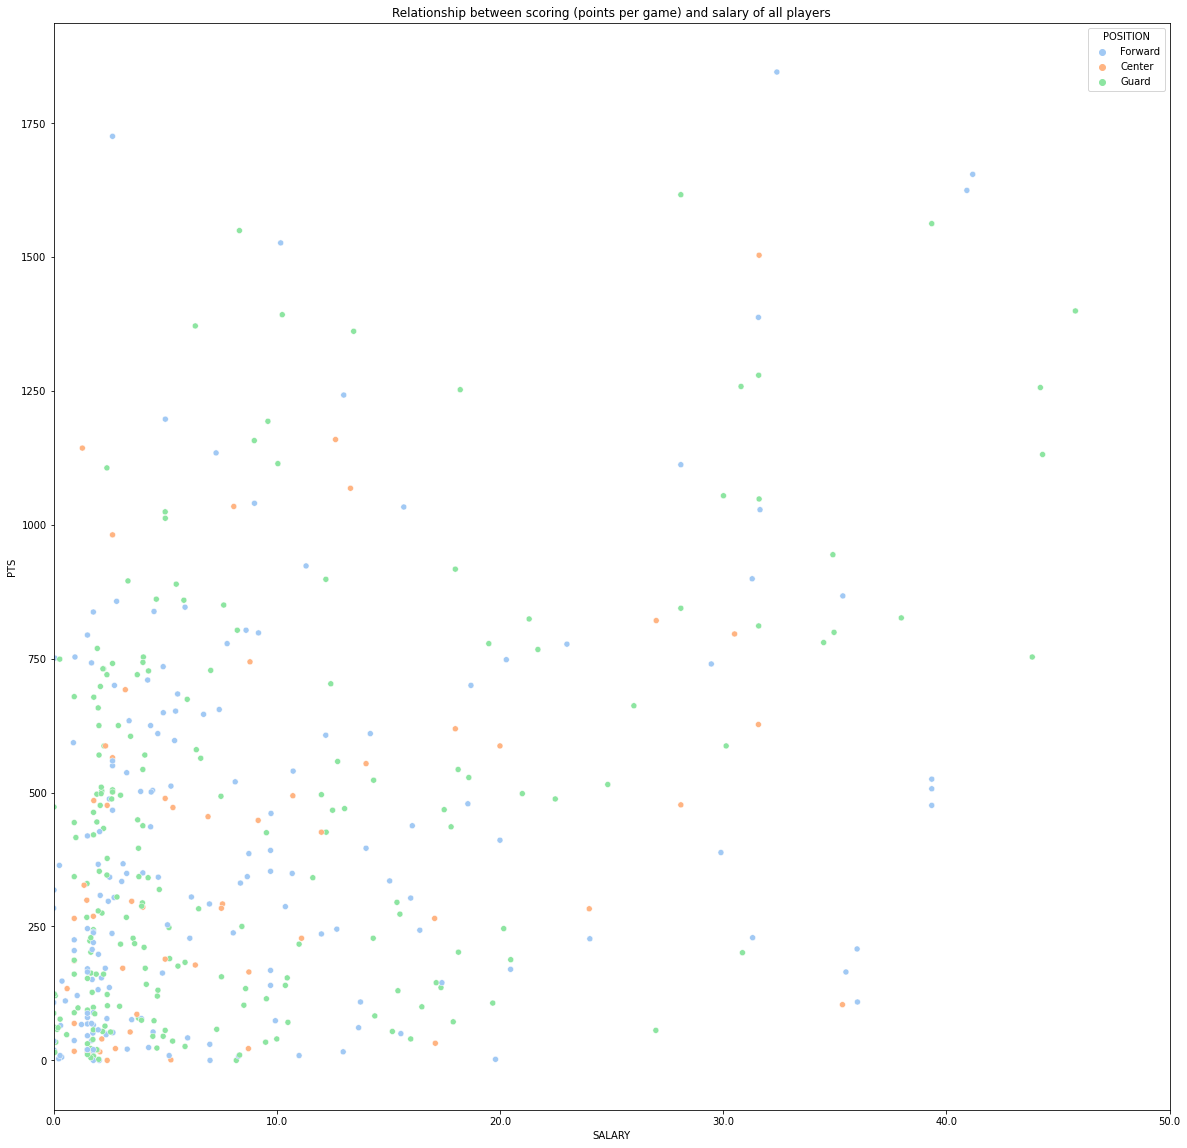

In [ ]:
# Create plot
g = sns.scatterplot(data=working_df, x="SALARY",y="PTS",palette="pastel",hue="POSITION")

# Convert salary to dollars
plt.xticks(g.get_xticks(),g.get_xticks()/1000000)

# X start in 0
plt.xlim(left=0)

# Add title
g.set_title("Relationship between scoring (points per game) and salary of all players")

plt.show()

-------------------- 3.3 --------------------

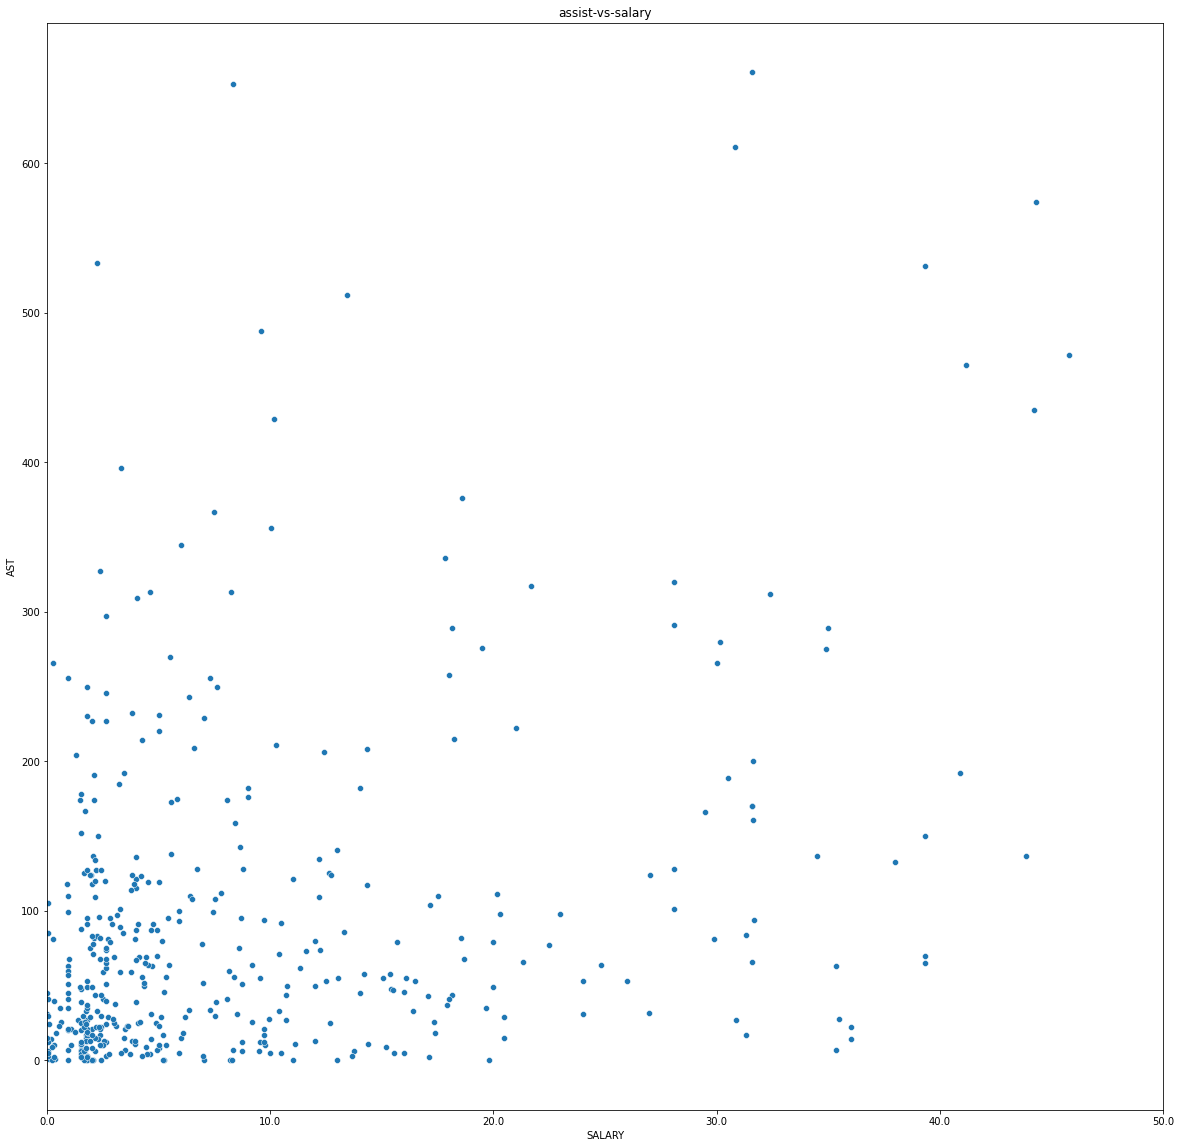

In [ ]:
# Create plot
g1 = sns.scatterplot(data=working_df, x="SALARY",y="AST",palette="pastel",)

# Convert salary to dollars
plt.xticks(g1.get_xticks(),g1.get_xticks()/1000000) 

# X Start in 0
plt.xlim(left=0)

# Add title
g1.set_title("assist-vs-salary")

plt.show()

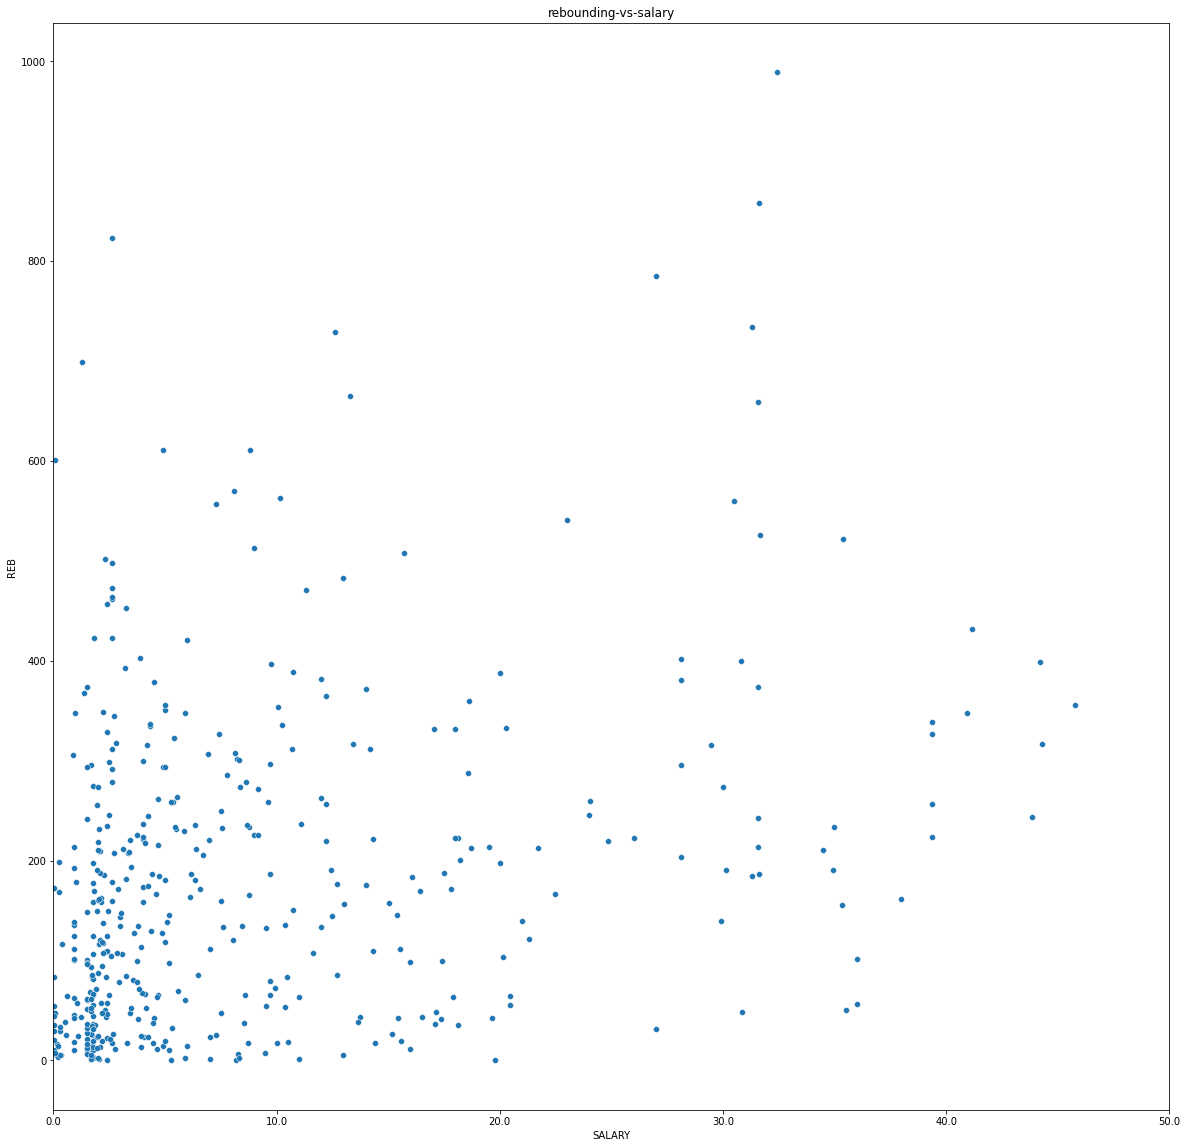

In [ ]:
# Create plot
g2 = sns.scatterplot(data=working_df, x="SALARY",y="REB",palette="pastel",)

# Convert salary to dollars
plt.xticks(g2.get_xticks(),g2.get_xticks()/1000000)

# X Start in 0
plt.xlim(left=0)

# Add title
g2.set_title("rebounding-vs-salary")

plt.show()

-------------------- POINT 3.4 --------------------

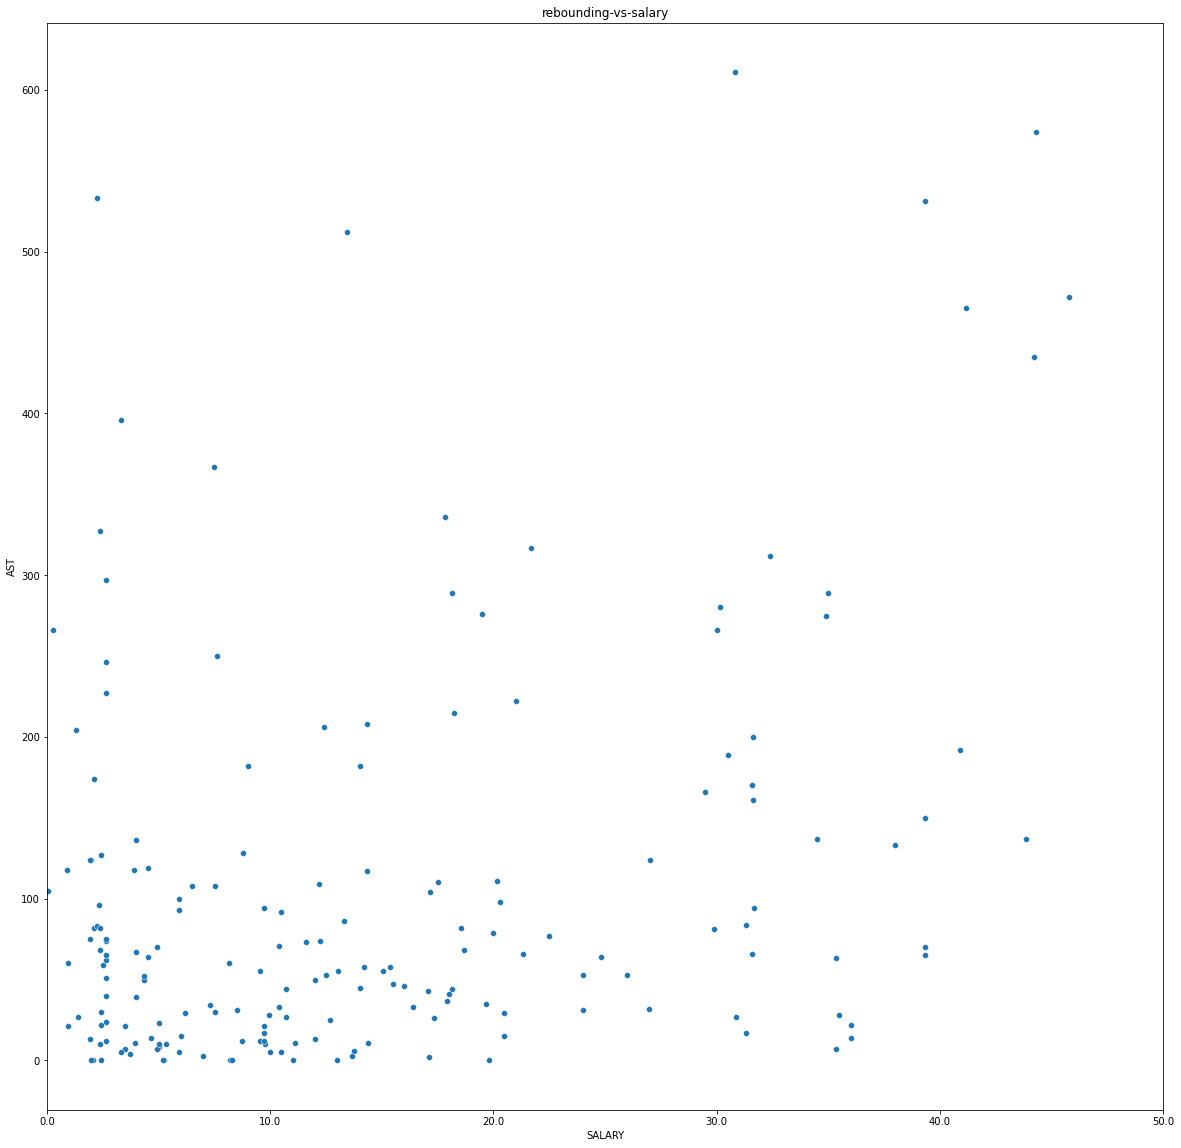

In [ ]:
# Players with more than four years of experience
Experience = working_df[working_df.SEASON_EXP > 4]

# Create plot
g3 = sns.scatterplot(data=Experience,x="SALARY",y="AST")

# Convert salary to dollars
plt.xticks(g3.get_xticks(),g3.get_xticks()/1000000)

# X Start in 0
plt.xlim(left=0)

# Add title
g3.set_title("rebounding-vs-salary")

plt.show()

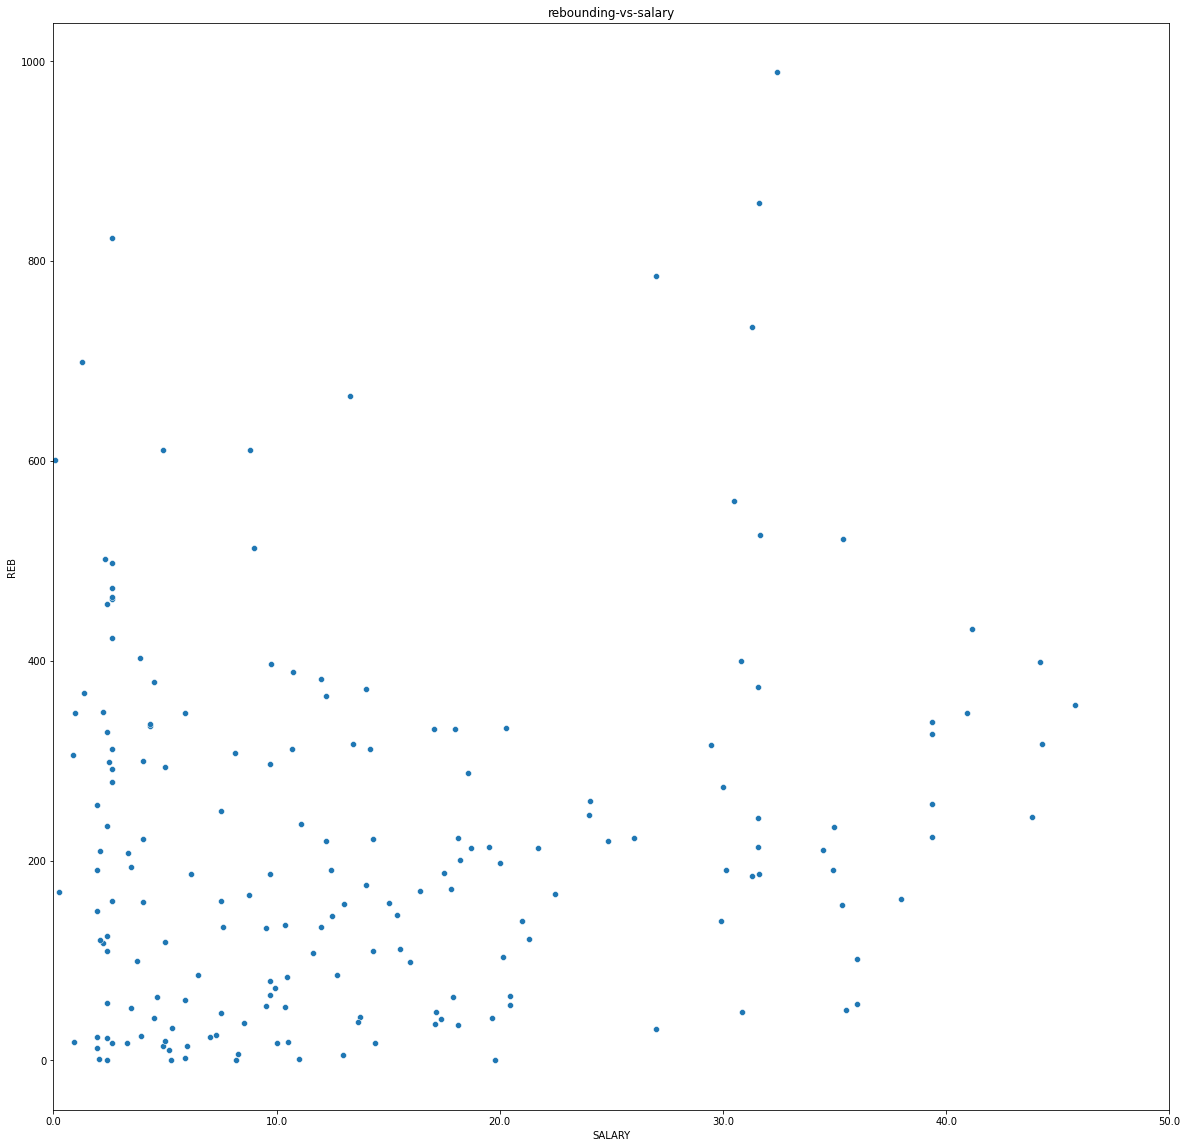

In [ ]:
# Players with more than four years of experience
Experience = working_df[working_df.SEASON_EXP > 4]

# Create plot
g3 = sns.scatterplot(data=Experience,x="SALARY",y="REB")

# Convert salary to dollars
plt.xticks(g3.get_xticks(),g3.get_xticks()/1000000)

# X Start in 0
plt.xlim(left=0)

# Add title
g3.set_title("rebounding-vs-salary")

plt.show()

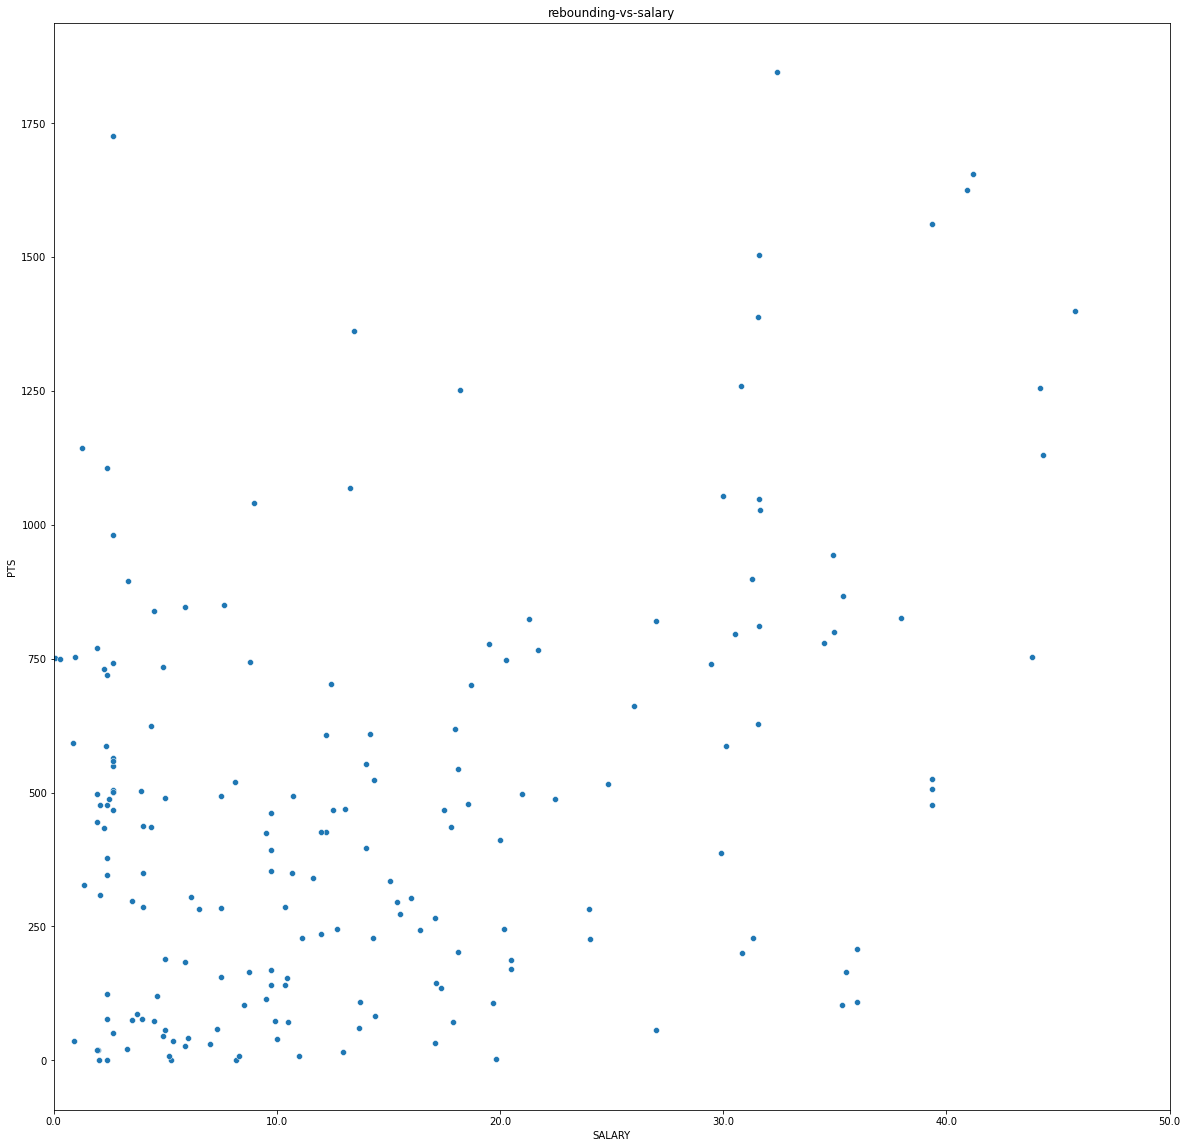

In [ ]:
# Players with more than four years of experience
Experience = working_df[working_df.SEASON_EXP > 4]

# Create plot
g3 = sns.scatterplot(data=Experience,x="SALARY",y="PTS")

# Convert salary to dollars
plt.xticks(g3.get_xticks(),g3.get_xticks()/1000000)

# X Start in 0
plt.xlim(left=0)

# Add title
g3.set_title("rebounding-vs-salary")

plt.show()

-------------------- 3.5 --------------------

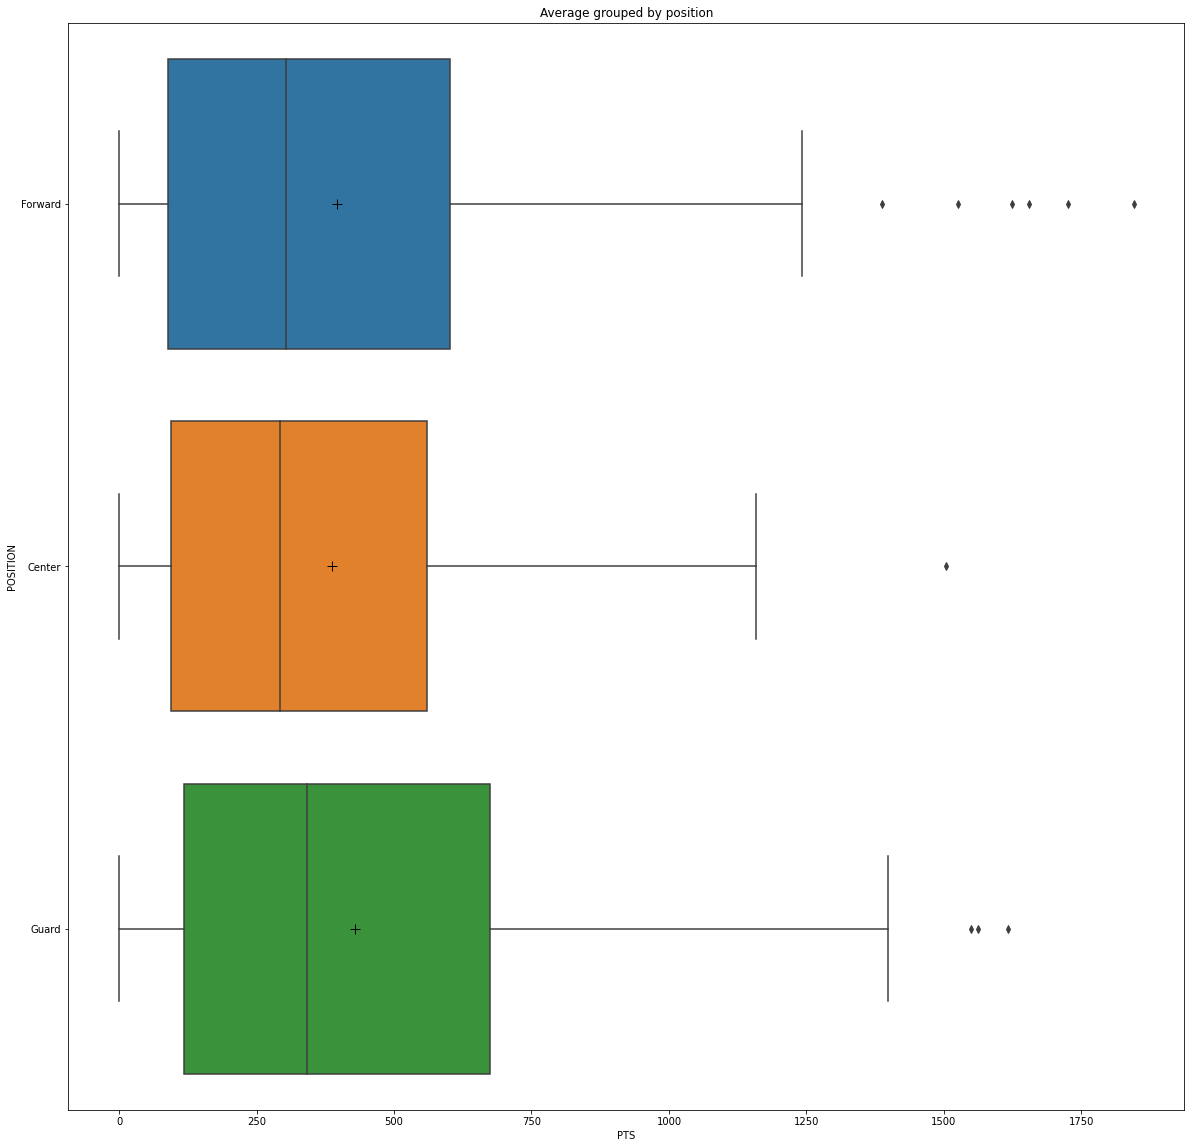

In [ ]:
# Create plot
g5 = sns.boxplot(data=working_df,y="POSITION",x="PTS",
            showmeans=True,meanprops={
                "marker": "+",
                "markeredgecolor": "black",
                "markersize": "10"})

# Add title
g5.set_title("Average grouped by position")

plt.show()

-------------------- 3.6 --------------------

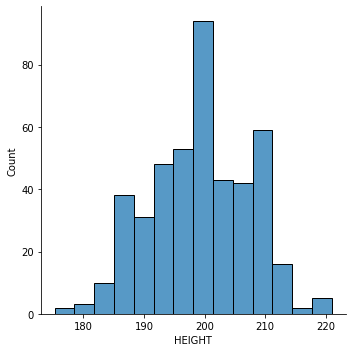

In [ ]:
# Create plot
g6 = sns.displot(data=working_df, x="HEIGHT")

# Add title
g6.set_titles("Height distribution of all players")

# We enlarge the graph
plt.rcParams["figure.figsize"] = (20, 20)

plt.show()

OPTIONAL

In [ ]:
# Total PLayers Country
players_total_country = working_df.COUNTRY.value_counts().rename_axis("name").reset_index(name="TotalPLayersCountry")

# Convert to str
players_total_country.name.apply(str)

# Word Data Frame
word = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Rename Country
players_total_country.name = players_total_country.name.replace((["USA"]),"United States of America")
players_total_country.name = players_total_country.name.replace((["Dominican Republic"]),"Dominican Rep.")
players_total_country.name = players_total_country.name.replace((["Czech Republic"]),"Czechia")
players_total_country.name = players_total_country.name.replace((["South Sudan"]),"S. Sudan")
players_total_country.name = players_total_country.name.replace((["Republic of the Cong"]),"Congo")

# Create DataFrame final
f = pd.merge(players_total_country,word,on="name",how="right")

# Add coordinates
gdfd = geopandas.GeoDataFrame(
       f, geometry=f.geometry)

# We enlarge the graph
plt.rcParams["figure.figsize"] = (20, 20)

# Print Map
gdfd.plot(column='TotalPLayers', cmap='OrRd', edgecolor='k', categorical=True, legend=True,missing_kwds={'color': 'white'})